In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_squared_error

import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import random
from deap import base, creator, tools, algorithms
import model.tank_model as tank_model

# 城市扩张方程

In [3]:

# 城市不透水面积占总城市面积的比重
# Proportion of urban impervious area to Taihu Lake Basin
data = {
    'Year': [1989,2000, 2005, 2010, 2015, 2018,2050],
    'Impervious Area': [0.1, 0.5, 7.1, 12.1, 13.1, 13.4, 15.0],
}

df = pd.DataFrame(data)

## 线性回归

In [4]:
from sklearn.linear_model import LinearRegression

# 创建线性回归模型
model = LinearRegression()

# 使用年份和土地扩张数据来拟合模型
model.fit(df[['Year']], df['Land_Expand'])

# 打印模型参数
print("Intercept: ", model.intercept_)
print("Coefficient: ", model.coef_[0])

Intercept:  -1411.0532833020643
Coefficient:  0.706754221388368


线性回归模型对于城市扩张问题不合适，因为城市扩张的增长速度是非线性的。我们可以使用多项式回归模型来拟合数据，这样就可以得到一个非线性的模型。

## 非线性回归

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 使用2阶多项式回归模型
degree = 6

# 创建一个包含多项式回归的pipeline
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# 将年份和土地扩张量转换为NumPy数组
X = np.array(data['Year']).reshape(-1, 1)
y = np.array(data['Impervious Area'])

# 训练模型
model.fit(X, y)

# 预测
years = np.array(range(1989, 2051)).reshape(-1, 1)
predicted_land_expansion = model.predict(years)

# 创建一个新的DataFrame来存储预测结果
predicted_df = pd.DataFrame({
    'Year': years.flatten(),
    'Predicted_land_expansion': predicted_land_expansion
})

print(predicted_df)

    Year  Predicted_land_expansion
0   1989                 -0.490473
1   1990                 -0.367343
2   1991                 -0.195159
3   1992                  0.023954
4   1993                  0.287863
..   ...                       ...
57  2046                 18.587243
58  2047                 17.812838
59  2048                 16.949719
60  2049                 15.995153
61  2050                 14.946398

[62 rows x 2 columns]


结果也是不合适的，因为存在了负值。这里设想扩张反映的是一个人口增长曲线（或者说逻辑增长曲线）的形状，可能使用Logistic模型更合适。这种模型通常用于描述在一开始增长速度较快，然后随着接近某个上限值增长速度逐渐减慢的过程。

## Logisitic Regression

    Year  Predicted_impervious_area
0   1989                       0.01
1   1990                       0.01
2   1991                       0.02
3   1992                       0.03
4   1993                       0.05
..   ...                        ...
57  2046                      13.80
58  2047                      13.80
59  2048                      13.80
60  2049                      13.80
61  2050                      13.80

[62 rows x 2 columns]


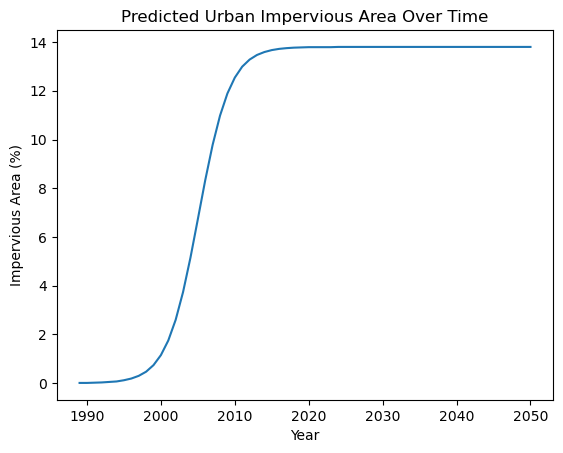

In [15]:
from scipy.optimize import curve_fit

# 定义逻辑函数
def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

# 将年份和土地扩张量转换为NumPy数组
X = np.array(df['Year'])
y = np.array(df['Impervious Area'])

# 初始猜测
p0 = [1, np.mean(X), np.max(y)]  # a, b, c
popt, _ = curve_fit(logistic_model, X, y, p0, maxfev=5000)

# 使用优化后的参数预测
years = np.array(range(1989, 2051))
predicted_impervious_area = logistic_model(years, *popt)

# 创建一个新的DataFrame来存储预测结果
impervious_area = pd.DataFrame({
    'Year': years,
    'Predicted_impervious_area': np.round(predicted_impervious_area,2)
})

print(impervious_area)

# Plot the predicted land expansion against the years
plt.plot(impervious_area['Year'], impervious_area['Predicted_impervious_area'])
plt.xlabel('Year')
plt.ylabel('Impervious Area (%)')
plt.title('Predicted Urban Impervious Area Over Time')
plt.show()


In [16]:
impervious_area.set_index('Year', inplace=True)
impervious_area.to_csv('../data/intermediate/Urban_Impervious_Area.csv')

# Tank model without Urban Impervious Area

## Model

In [29]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
precip = fengqiao['precipitation']
discharge = fengqiao['discharge']
et = mete['ETo_PM']

# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'kc': (0.1, 1.5),
    'k1': (0.00, 0.6),
    'k2': (0.01, 0.5),
    'k3': (0.01, 0.5),
    'A': (0, 3690),
}

def model_error(params):
    kc, k1, k2, k3, A = params['kc'], params['k1'], params['k2'], params['k3'], params['A']
    _, _, outflow = tank_model.tank_model_Q2_impervious_area(precip, et, k1, k2, k3, A, kc, impervious_area=None)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # For BayesianOptimization, we maximize the function. Therefore, use negative MSE.

optimizer = BayesianOptimization(
    lambda k1, k2, k3, A, kc: model_error({'k1': k1, 'k2': k2, 'k3': k3, 'A': A, 'kc': kc}),
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=50,
)

best_params = optimizer.max['params']

if best_params is not None:
    kc_opt = best_params['kc']
    k1_opt = best_params['k1']
    k2_opt = best_params['k2']
    k3_opt = best_params['k3']
    A_opt = best_params['A']
else:
    # Handle the case where no optimal parameters were found
    kc_opt = 0.5
    k1_opt = 0.1
    k2_opt = 0.1
    k3_opt = 0.1
    A_opt = 1000
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model.tank_model_Q2_impervious_area(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt,k3_opt, A_opt, kc_opt, impervious_area=None)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

|   iter    |  target   |     A     |    k1     |    k2     |    k3     |    kc     |
-------------------------------------------------------------------------------------
| 1         | -9.579e+0 | 1.539e+03 | 0.4322    | 0.01006   | 0.1581    | 0.3055    |
| 2         | -2.463e+0 | 340.7     | 0.1118    | 0.1793    | 0.2044    | 0.8543    |
| 3         | -1.017e+0 | 1.547e+03 | 0.4111    | 0.1102    | 0.4403    | 0.1383    |
| 4         | -1.177e+0 | 2.474e+03 | 0.2504    | 0.2838    | 0.07879   | 0.3773    |
| 5         | -4.441e+0 | 2.955e+03 | 0.581     | 0.1636    | 0.3492    | 1.327     |
| 6         | -3.921e+0 | 3.301e+03 | 0.05103   | 0.02914   | 0.09322   | 1.329     |
| 7         | -2.477e+0 | 362.9     | 0.2527    | 0.4794    | 0.2713    | 1.069     |
| 8         | -3.909e+0 | 1.164e+03 | 0.4119    | 0.419     | 0.01896   | 1.15      |
| 9         | -6.634e+0 | 3.649e+03 | 0.4489    | 0.1474    | 0.3967    | 0.2445    |
| 10        | -1.412e+0 | 1.653e+03 | 0.5452    | 0.15

## Error

In [37]:
# 均方误差 (Mean Squared Error, MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)

# 平均绝对误差 (Mean Absolute Error, MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)
from sklearn.metrics import r2_score
r2 = r2_score(fengqiao['discharge'], tank_results_opt['Outflow'])
print('R2: ', r2)

MSE:  853.3461762826225
RMSE:  29.212089556938967
MAE:  23.869847334234905
R2:  -0.6541741850141733


## Figure

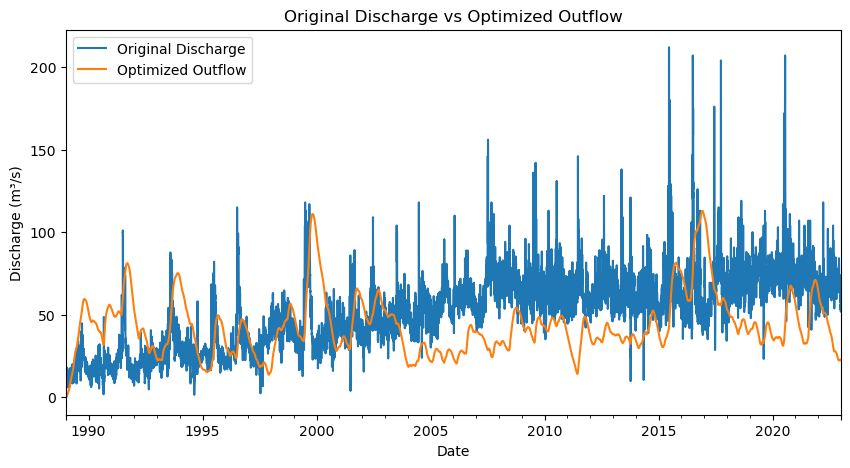

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

# Tank model with impervious area

## Model

|   iter    |  target   |     A     |    k1     |    k2     |    k3     |    kc     |
-------------------------------------------------------------------------------------
| 1         | -2.6e+03  | 1.539e+03 | 0.4322    | 0.01006   | 0.1581    | 0.2321    |
| 2         | -2.417e+0 | 340.7     | 0.1118    | 0.1793    | 0.2044    | 0.5849    |
| 3         | -4.073e+0 | 1.547e+03 | 0.4111    | 0.1102    | 0.4403    | 0.1246    |
| 4         | -6.191e+0 | 2.474e+03 | 0.2504    | 0.2838    | 0.07879   | 0.2783    |
| 5         | -1.542e+0 | 2.955e+03 | 0.581     | 0.1636    | 0.3492    | 0.8888    |
| 6         | -2.895e+0 | 3.301e+03 | 0.05103   | 0.02914   | 0.09322   | 0.8903    |
| 7         | -2.348e+0 | 362.9     | 0.2527    | 0.4794    | 0.2713    | 0.7227    |
| 8         | -1.576e+0 | 1.164e+03 | 0.4119    | 0.419     | 0.01896   | 0.7751    |
| 9         | -2.91e+04 | 3.649e+03 | 0.4489    | 0.1474    | 0.3967    | 0.1929    |
| 10        | -4.67e+03 | 1.653e+03 | 0.5452    | 0.15

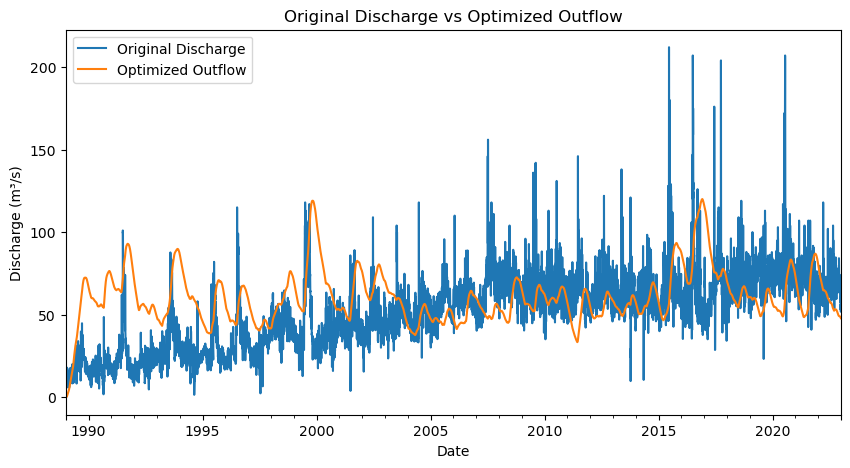

In [4]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
precip = fengqiao['precipitation']
discharge = fengqiao['discharge']
et = mete['ETo_PM']
impervious_area = pd.read_csv('../data/intermediate/Urban_Impervious_Area.csv', index_col=0)

# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'kc': (0.1, 1),
    'k1': (0.00, 0.6),
    'k2': (0.01, 0.5),
    'k3': (0.01, 0.5),
    'A': (0, 3690),
}

def model_error(params):
    kc, k1, k2, k3, A = params['kc'], params['k1'], params['k2'], params['k3'], params['A']
    _, _, outflow = tank_model.tank_model_Q2_impervious_area(precip, et, k1, k2, k3, A, kc, impervious_area=impervious_area)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # For BayesianOptimization, we maximize the function. Therefore, use negative MSE.

optimizer = BayesianOptimization(
    lambda k1, k2, k3, A, kc: model_error({'k1': k1, 'k2': k2, 'k3': k3, 'A': A, 'kc': kc}),
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=50,
)

best_params = optimizer.max['params']

if best_params is not None:
    kc_opt = best_params['kc']
    k1_opt = best_params['k1']
    k2_opt = best_params['k2']
    k3_opt = best_params['k3']
    A_opt = best_params['A']
else:
    # Handle the case where no optimal parameters were found
    kc_opt = 0.5
    k1_opt = 0.1
    k2_opt = 0.1
    k3_opt = 0.1
    A_opt = 1000
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model.tank_model_Q2_impervious_area(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt,k3_opt, A_opt, kc_opt, impervious_area=impervious_area)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)
## Error
# 均方误差 (Mean Squared Error, MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)

# 平均绝对误差 (Mean Absolute Error, MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)
from sklearn.metrics import r2_score
r2 = r2_score(fengqiao['discharge'], tank_results_opt['Outflow'])
print('R2: ', r2)
## Figure
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

In [5]:
import numpy as np

# 计算相关性
correlation_matrix = np.corrcoef(fengqiao['discharge'], tank_results_opt['Outflow'])

# correlation_matrix是一个2x2的矩阵，我们需要的相关性是非对角线上的元素
correlation = correlation_matrix[0, 1]

print('Correlation: ', correlation)

Correlation:  0.08569327742463632


### 遗传算法（Genetic Algorithm）

In [7]:
from deap import base, creator, tools, algorithms
import random
import numpy as np

# Define the fitness function
def fitness(params):
    kc, k1, k2, k3, A = params
    try:
        _, _, outflow = tank_model.tank_model_Q2_impervious_area(precip, et, k1, k2, k3, A, kc, impervious_area=impervious_area)
        mse = mean_squared_error(discharge, outflow)
    except ValueError:
        # Return a large MSE if there is a numerical error
        mse = 1e10
    return mse,


# Define the individual and the population
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_kc", random.uniform, 0.1, 1.5)
toolbox.register("attr_k1", random.uniform, 0.00, 0.6)
toolbox.register("attr_k2", random.uniform, 0.01, 0.5)
toolbox.register("attr_k3", random.uniform, 0.01, 0.5)
toolbox.register("attr_A", random.uniform, 0, 3690)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_kc, toolbox.attr_k1, toolbox.attr_k2, toolbox.attr_k3, toolbox.attr_A), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the genetic operators
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and the number of generations
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the genetic algorithm
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, 
                               stats=stats, halloffame=hof, verbose=True)

# Get the best parameters
best_params = hof[0]
kc_opt = best_params[0]
k1_opt = best_params[1]
k2_opt = best_params[2]
k3_opt = best_params[3]
A_opt = best_params[4]

KeyError: 1989

            Surface_runoff   Baseflow    Outflow
Date                                            
1989-01-01    0.000000e+00   0.000000   0.000000
1989-01-02    0.000000e+00   0.000000   0.000000
1989-01-03    0.000000e+00   0.000000   0.000000
1989-01-04    0.000000e+00   0.000000   0.000000
1989-01-05    3.877119e-02   0.009580   0.048351
...                    ...        ...        ...
2022-12-27   7.613552e-321  30.363879  30.363879
2022-12-28   7.356637e-321  30.093748  30.093748
2022-12-29   7.114545e-321  29.809073  29.809073
2022-12-30   6.867512e-321  29.509764  29.509764
2022-12-31   6.610598e-321  29.195288  29.195288

[12418 rows x 3 columns]
MSE:  880.7286112105701
RMSE:  29.677072146870724
MAE:  23.635824821205414
R2:  -0.707253835734539


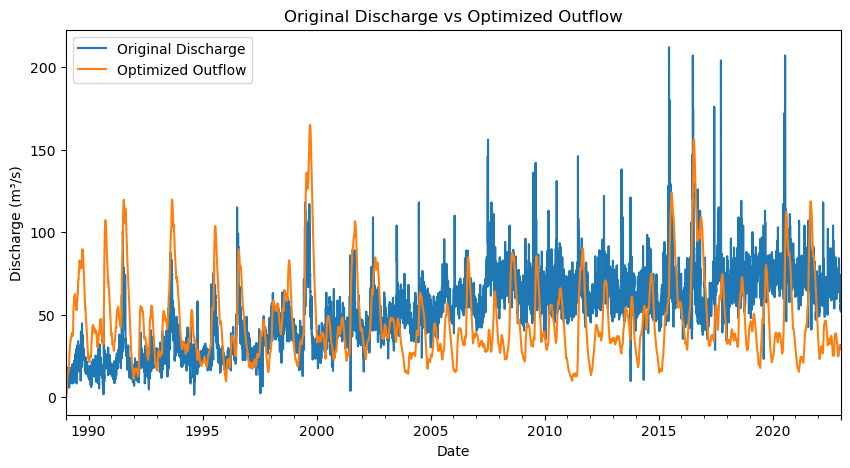

In [47]:
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model.tank_model_Q2_impervious_area(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt,k3_opt, A_opt, kc_opt, impervious_area=impervious_area)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)
## Error
# 均方误差 (Mean Squared Error, MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)

# 平均绝对误差 (Mean Absolute Error, MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(fengqiao['discharge'], tank_results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)
from sklearn.metrics import r2_score
r2 = r2_score(fengqiao['discharge'], tank_results_opt['Outflow'])
print('R2: ', r2)
## Figure
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

使用蚁群算法后，配合城市不透水面积参数的加入，整体变化上能很好的去预测了。但是由于数据存在趋势性部分，可以采用数据预处理。

数据预处理：在模型训练之前，对数据进行季节性分解，将数据分解为趋势、季节性和残差三部分。然后，使用去除了季节性的数据进行模型训练，最后再将模型预测的结果加上季节性部分，得到最终的预测结果。